# Demo Run

In [1]:
%load_ext autoreload
%autoreload 2
# this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import torch
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))

import tardis

local_run = True
if local_run:
    tardis.config = tardis.config_local
else:
    tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_subset_sex_2.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.shape

(15850, 2048)

In [5]:
sc.pp.filter_cells(adata, min_genes=10, inplace=True)
adata.shape

(13834, 2048)

In [6]:
disentenglement_targets_configurations = [
    dict(
        obs_key="sex",
        n_reserved_latent=1,
        counteractive_minibatch_settings=dict(
            method="random",
            method_kwargs=dict(
                within_labels=True,
                within_batch=False,
                within_categorical_covs=None,
                within_other_groups=True,
                seed="forward",
            ),
        ),
        losses=[
            dict(
                method="mse",
                weight=50.0,
                transformation="inverse",
                progress_bar=True,
                type="reserved",
            ),
            dict(
                method="mae",
                weight=1.0,
                transformation="none",
                progress_bar=False,
                type="unreserved",
            ),
            dict(
                method="mse",
                weight=0.010,
                transformation="negative",
                progress_bar=False,
                type="complete",
            ),
        ],
    )
]

model_params = dict(
    n_hidden=128,
    n_layers=2,
    n_latent=16,
    gene_likelihood="nb",
    dropout_rate=0.1,
    include_auxillary_loss=True,
)
train_params = dict(
    max_epochs=20,
    train_size=0.9,
    batch_size=128,
    check_val_every_n_epoch=10,
    plan_kwargs=dict(
        n_epochs_kl_warmup=400,
        # weight_decay=1e-3,
        # optimizer="AdamW"
    ),
)
dataset_params = dict(
    layer=None,
    labels_key="cell_type",
    batch_key="concatenated_integration_covariates",
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
)


tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
vae.train(**train_params)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aleynakara/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/aleynakara/Documents/tardis/tardis/_counteractiveminibatchgenerator.py:64: UserWarning: Possible group definition indices are calculating for `sex` for `training` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/aleynakara/Documents/tardis/tardis/_counteractiveminibatchgenerator.py:64: UserWarning: Number of elements in each group for `sex` in `training` set: 752,366,513,826,1274,790,298,1026,821,317,242,1120,402,1040,1221,174,223,1046
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 11/20:  50%|█████     | 10/20 [00:22<00:22,  2.29s/it, v_num=1, total_loss_train=128, kl_local_train=42.5, tardis|sex|complete|mse_train=-0.00269, tardis|sex|reserved|mse_train=37.9, tardis|sex|unreserved|mae_train=0.396]

/Users/aleynakara/Documents/tardis/tardis/_counteractiveminibatchgenerator.py:64: UserWarning: Possible group definition indices are calculating for `sex` for `validation` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/aleynakara/Documents/tardis/tardis/_counteractiveminibatchgenerator.py:64: UserWarning: Number of elements in each group for `sex` in `validation` set: 58,47,62,96,156,99,52,110,77,44,35,112,28,115,131,13,16,132
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 20/20: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it, v_num=1, total_loss_train=123, kl_local_train=37.1, tardis|sex|complete|mse_train=-0.00313, tardis|sex|reserved|mse_train=28.7, tardis|sex|unreserved|mae_train=0.37] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it, v_num=1, total_loss_train=123, kl_local_train=37.1, tardis|sex|complete|mse_train=-0.00313, tardis|sex|reserved|mse_train=28.7, tardis|sex|unreserved|mae_train=0.37]


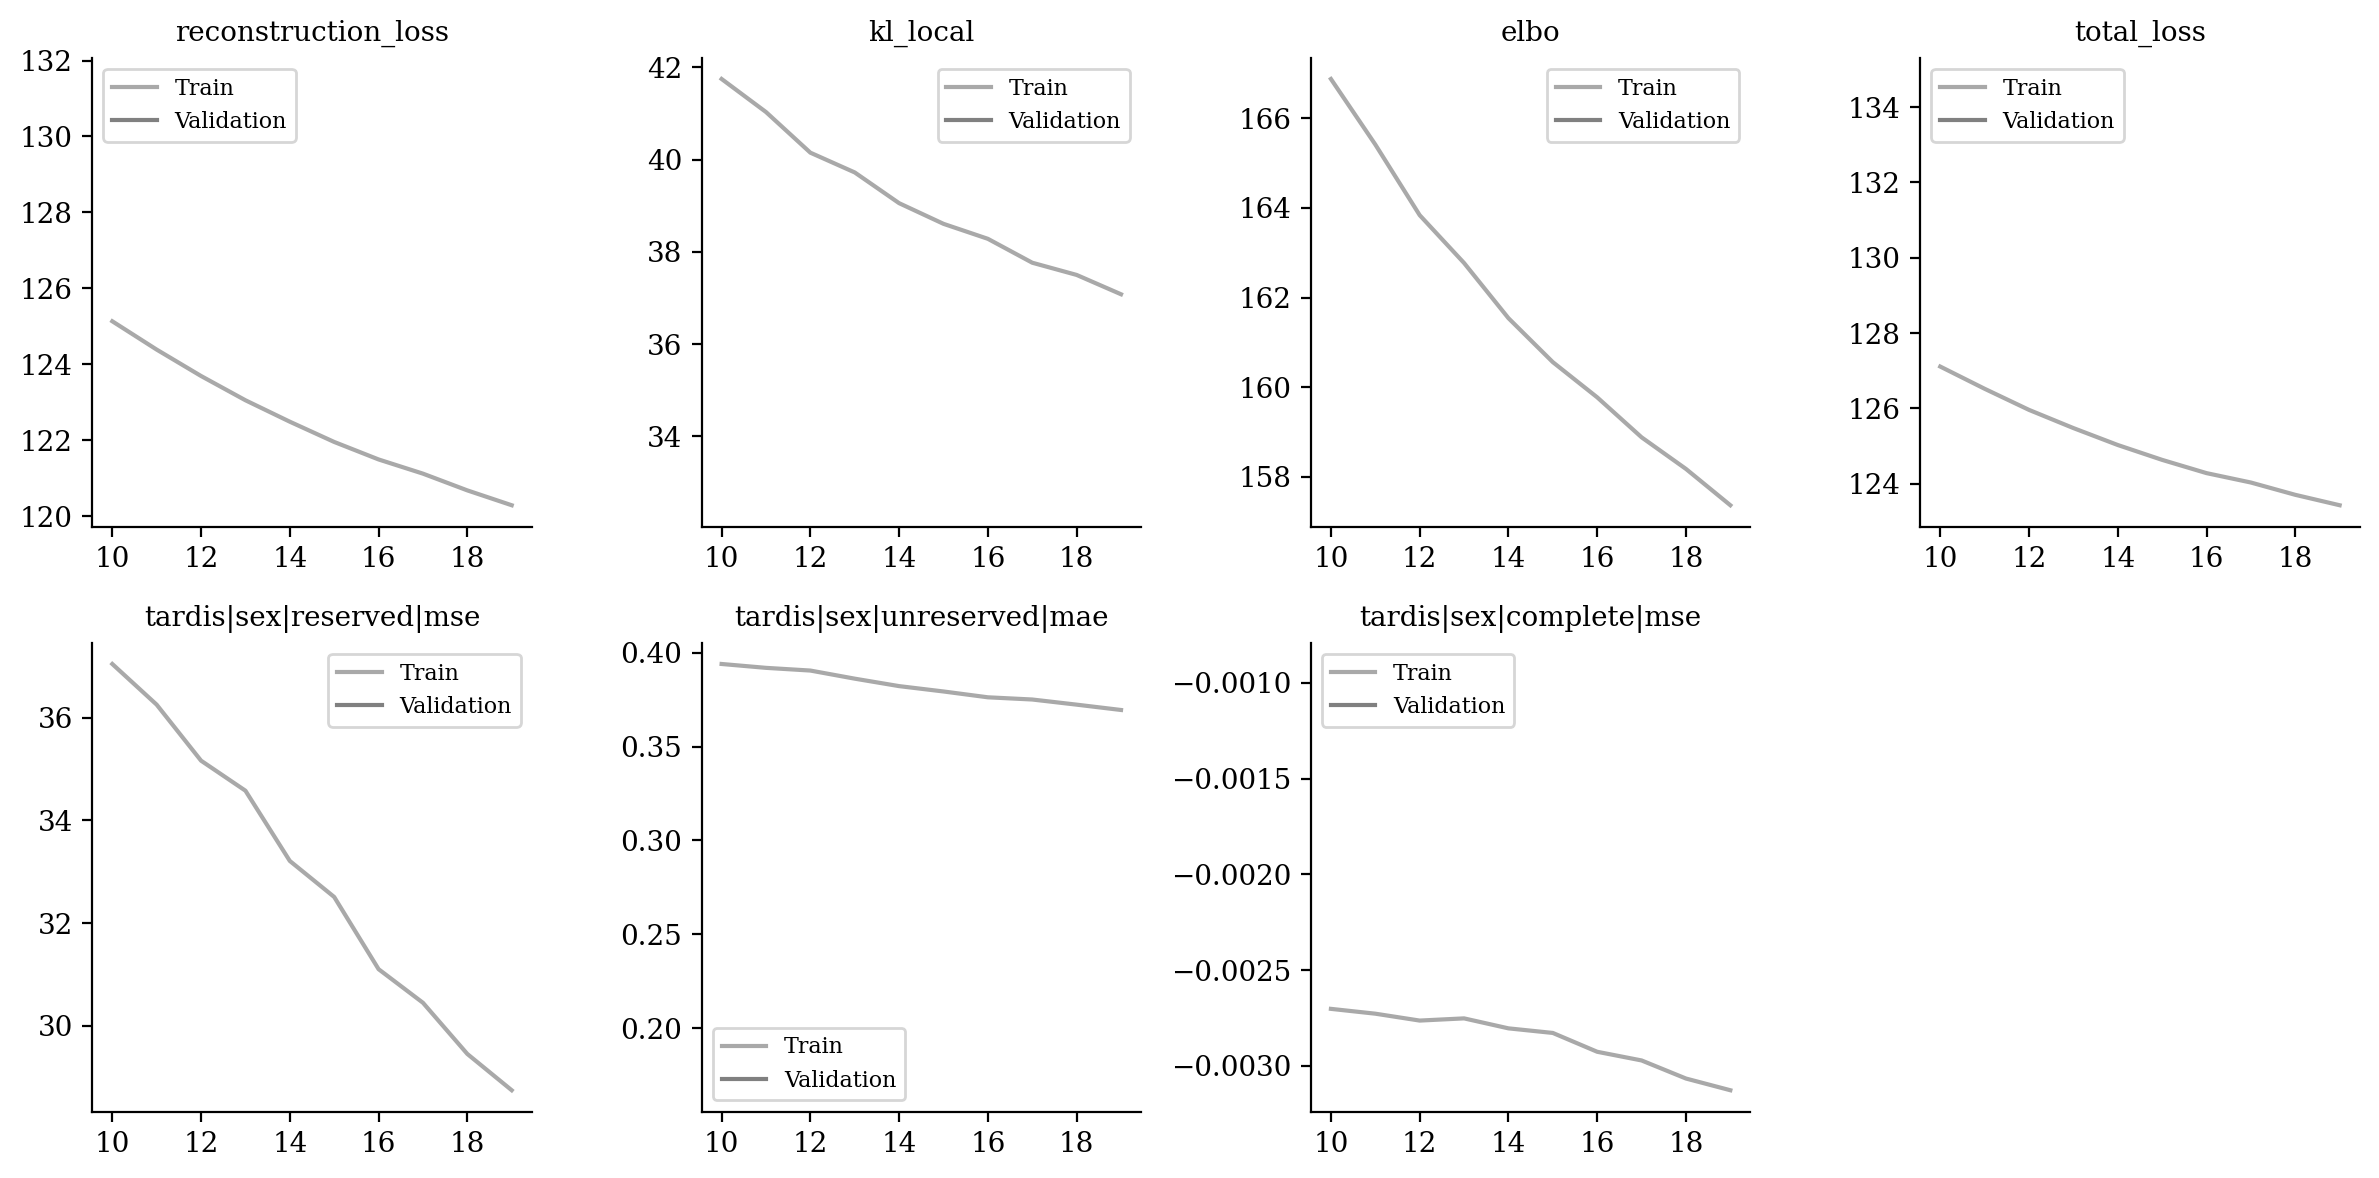

In [7]:
vae.plot_training_history(
    ignore_first=10, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        "tardis|sex|reserved|mse", 
        "tardis|sex|unreserved|mae", 
        "tardis|sex|complete|mse"
    ]
)

KeyError: 'tardis|sex|reserved|mae_train'

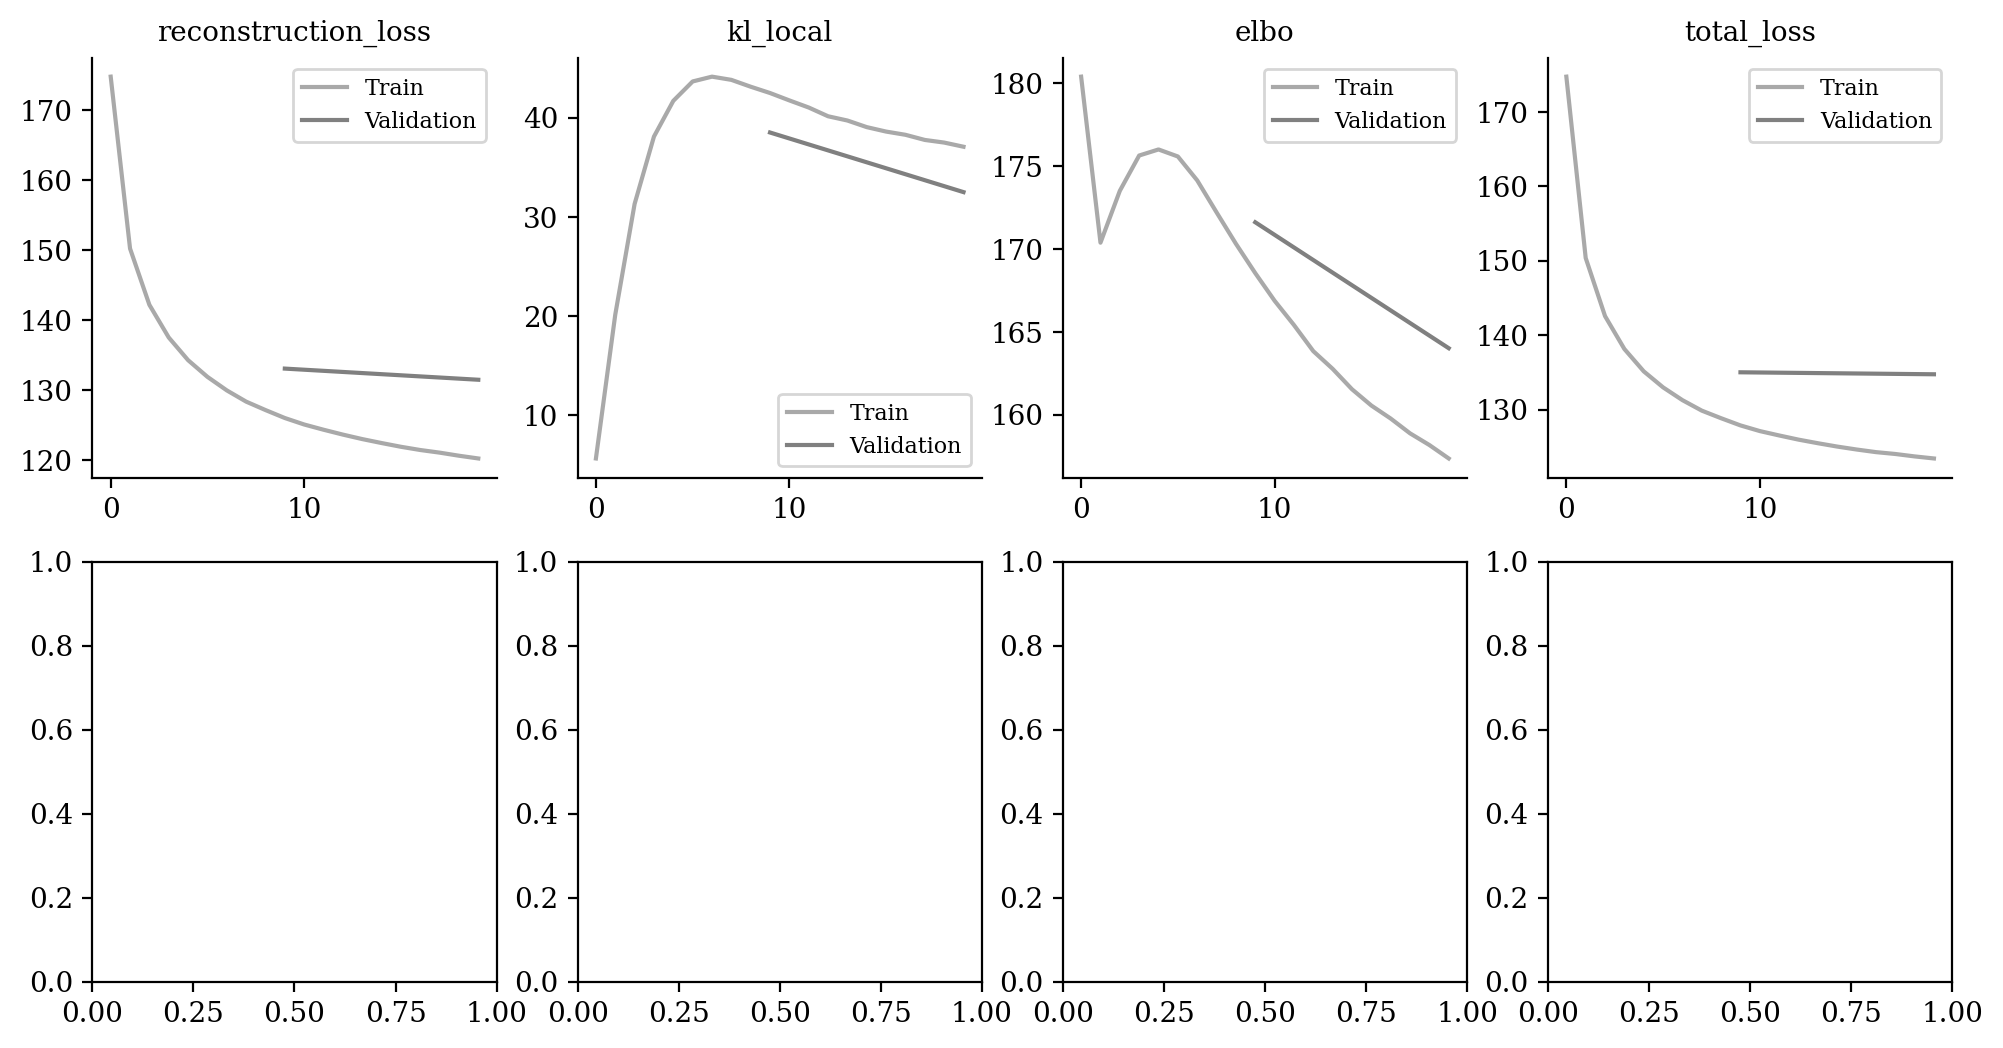

In [8]:
vae.plot_training_history(
    ignore_first=0, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        "tardis|sex|reserved|mae", 
        "tardis|sex|unreserved|", 
        "tardis|sex|complete_latent"
    ]
)

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
DisentenglementTargetManager.configurations.get_by_obs_key("sex").reserved_latent_indices

[0]

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


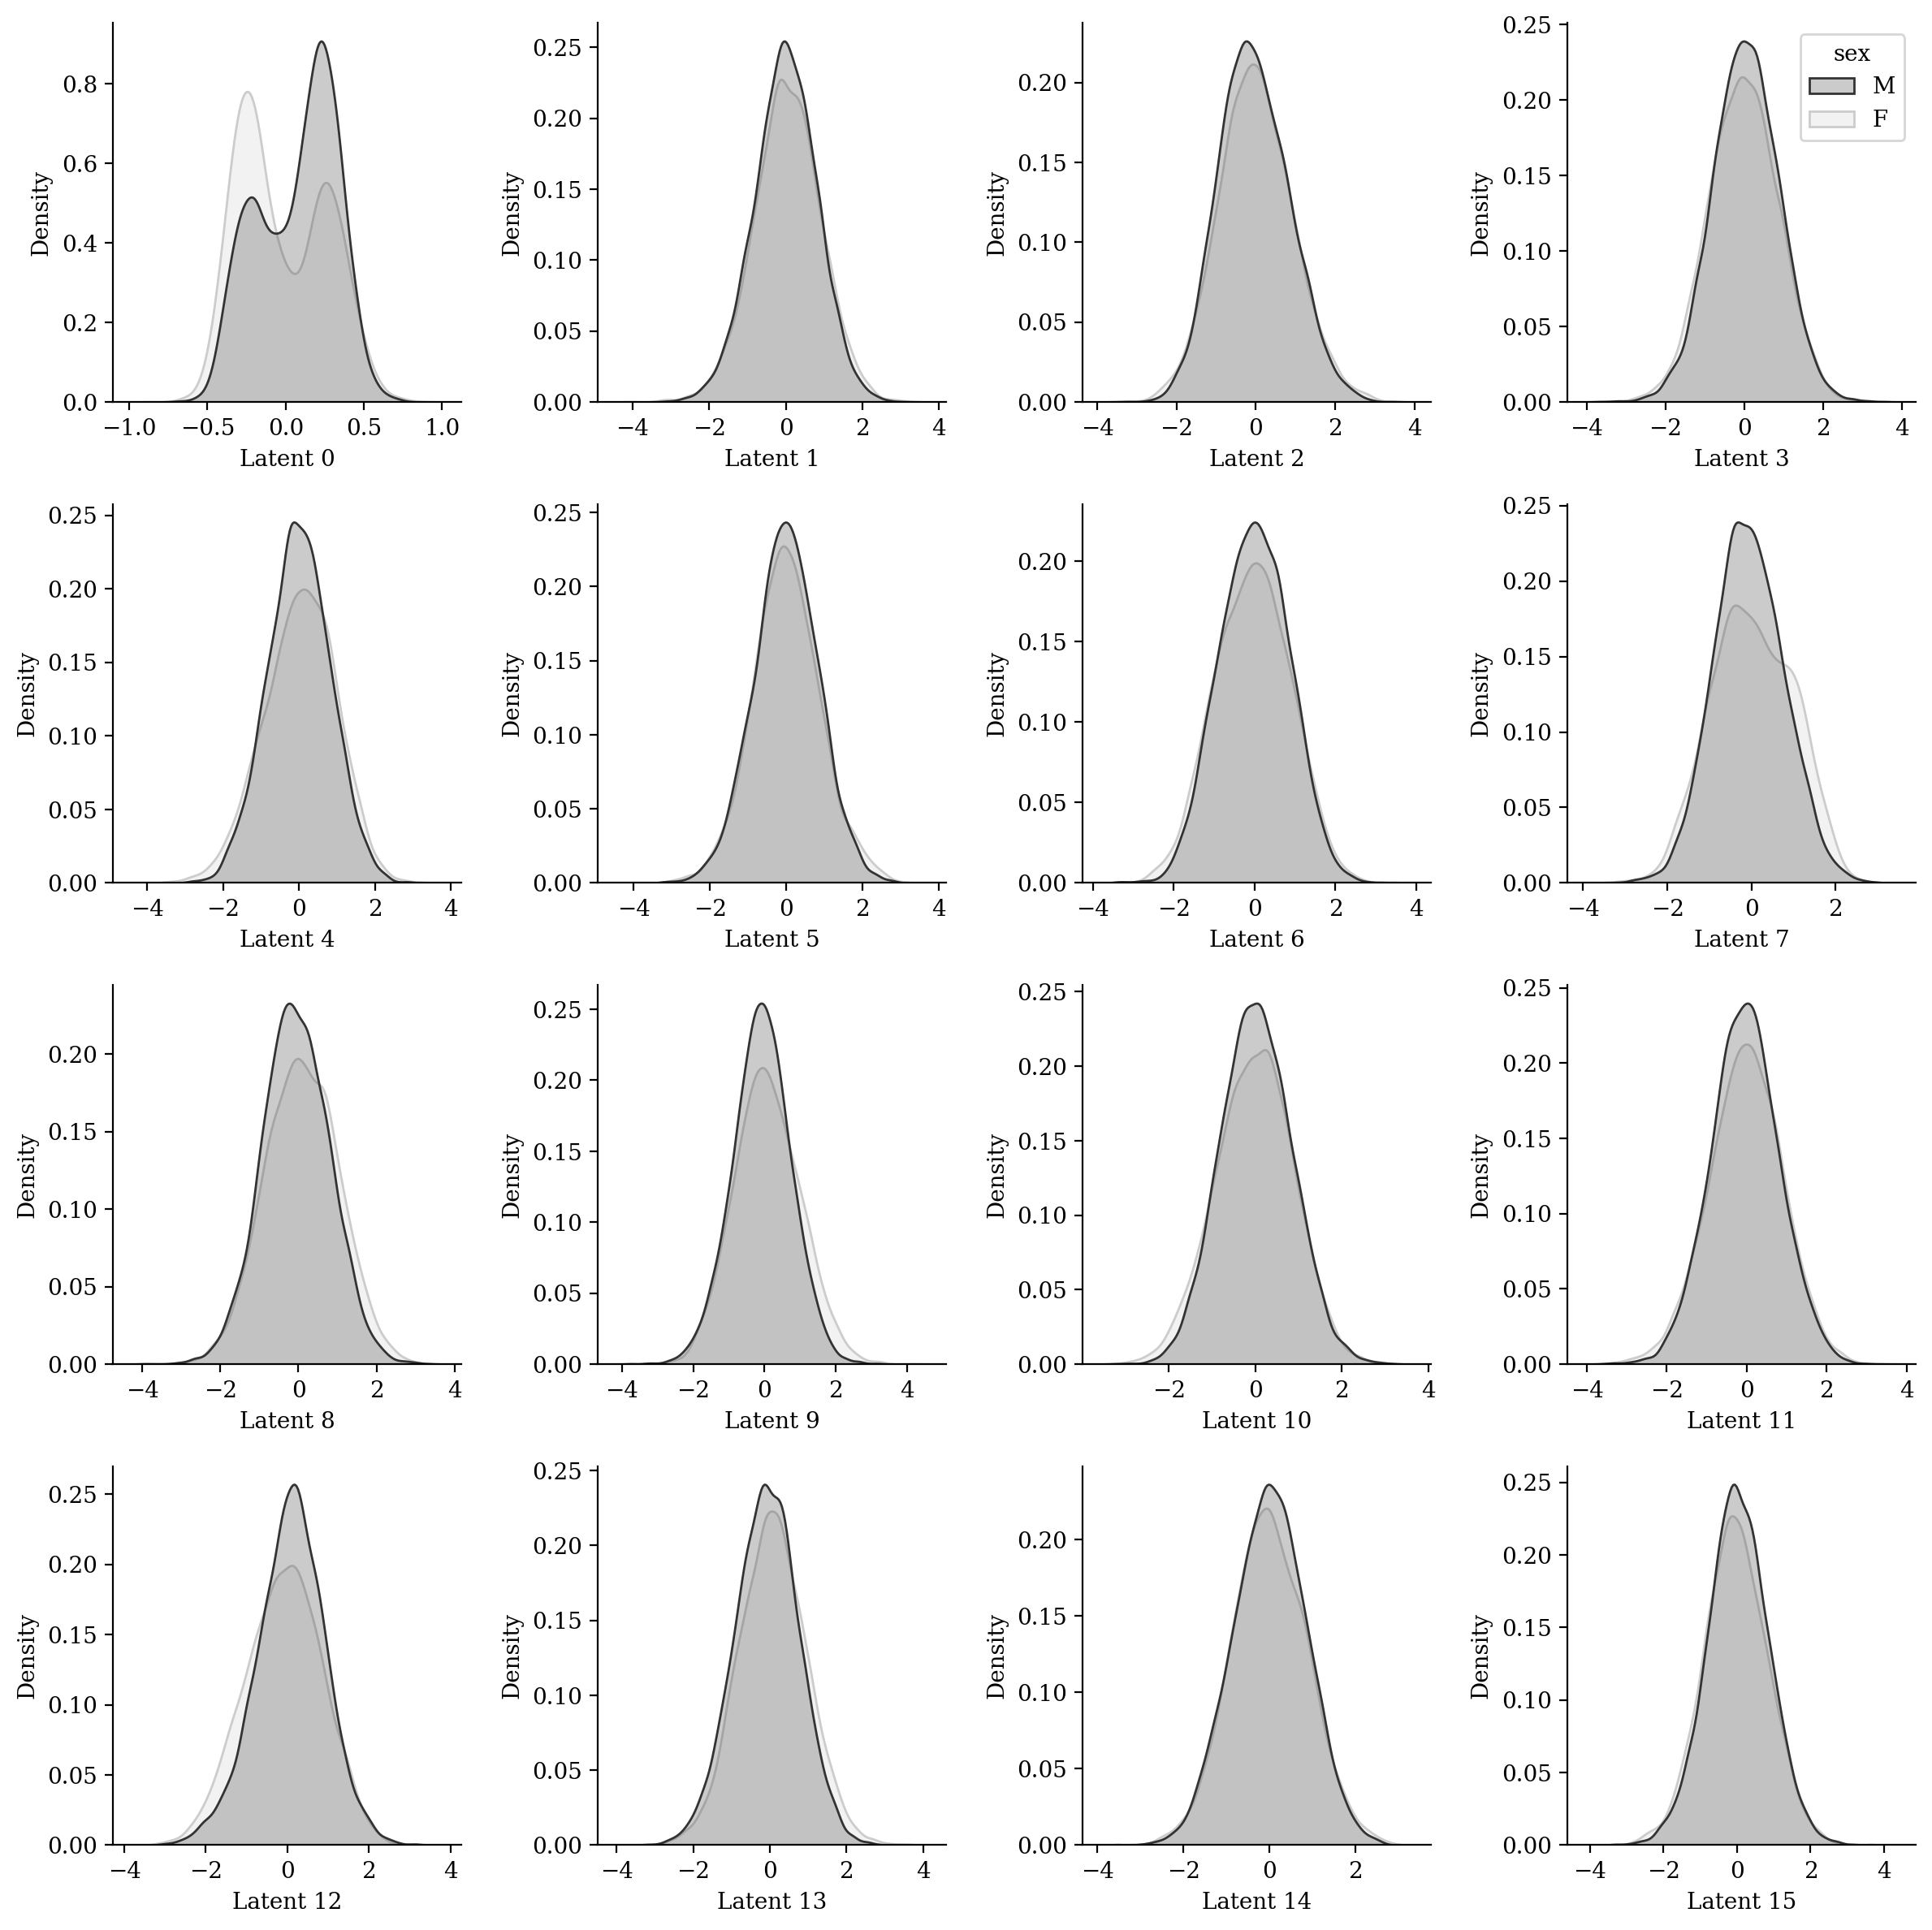

In [ ]:
vae.plot_latent_kde(
    adata_obs=adata.obs,
    target_obs_key="sex",
    latent_representation=vae.get_latent_representation(),
    latent_dim_of_interest=None
)

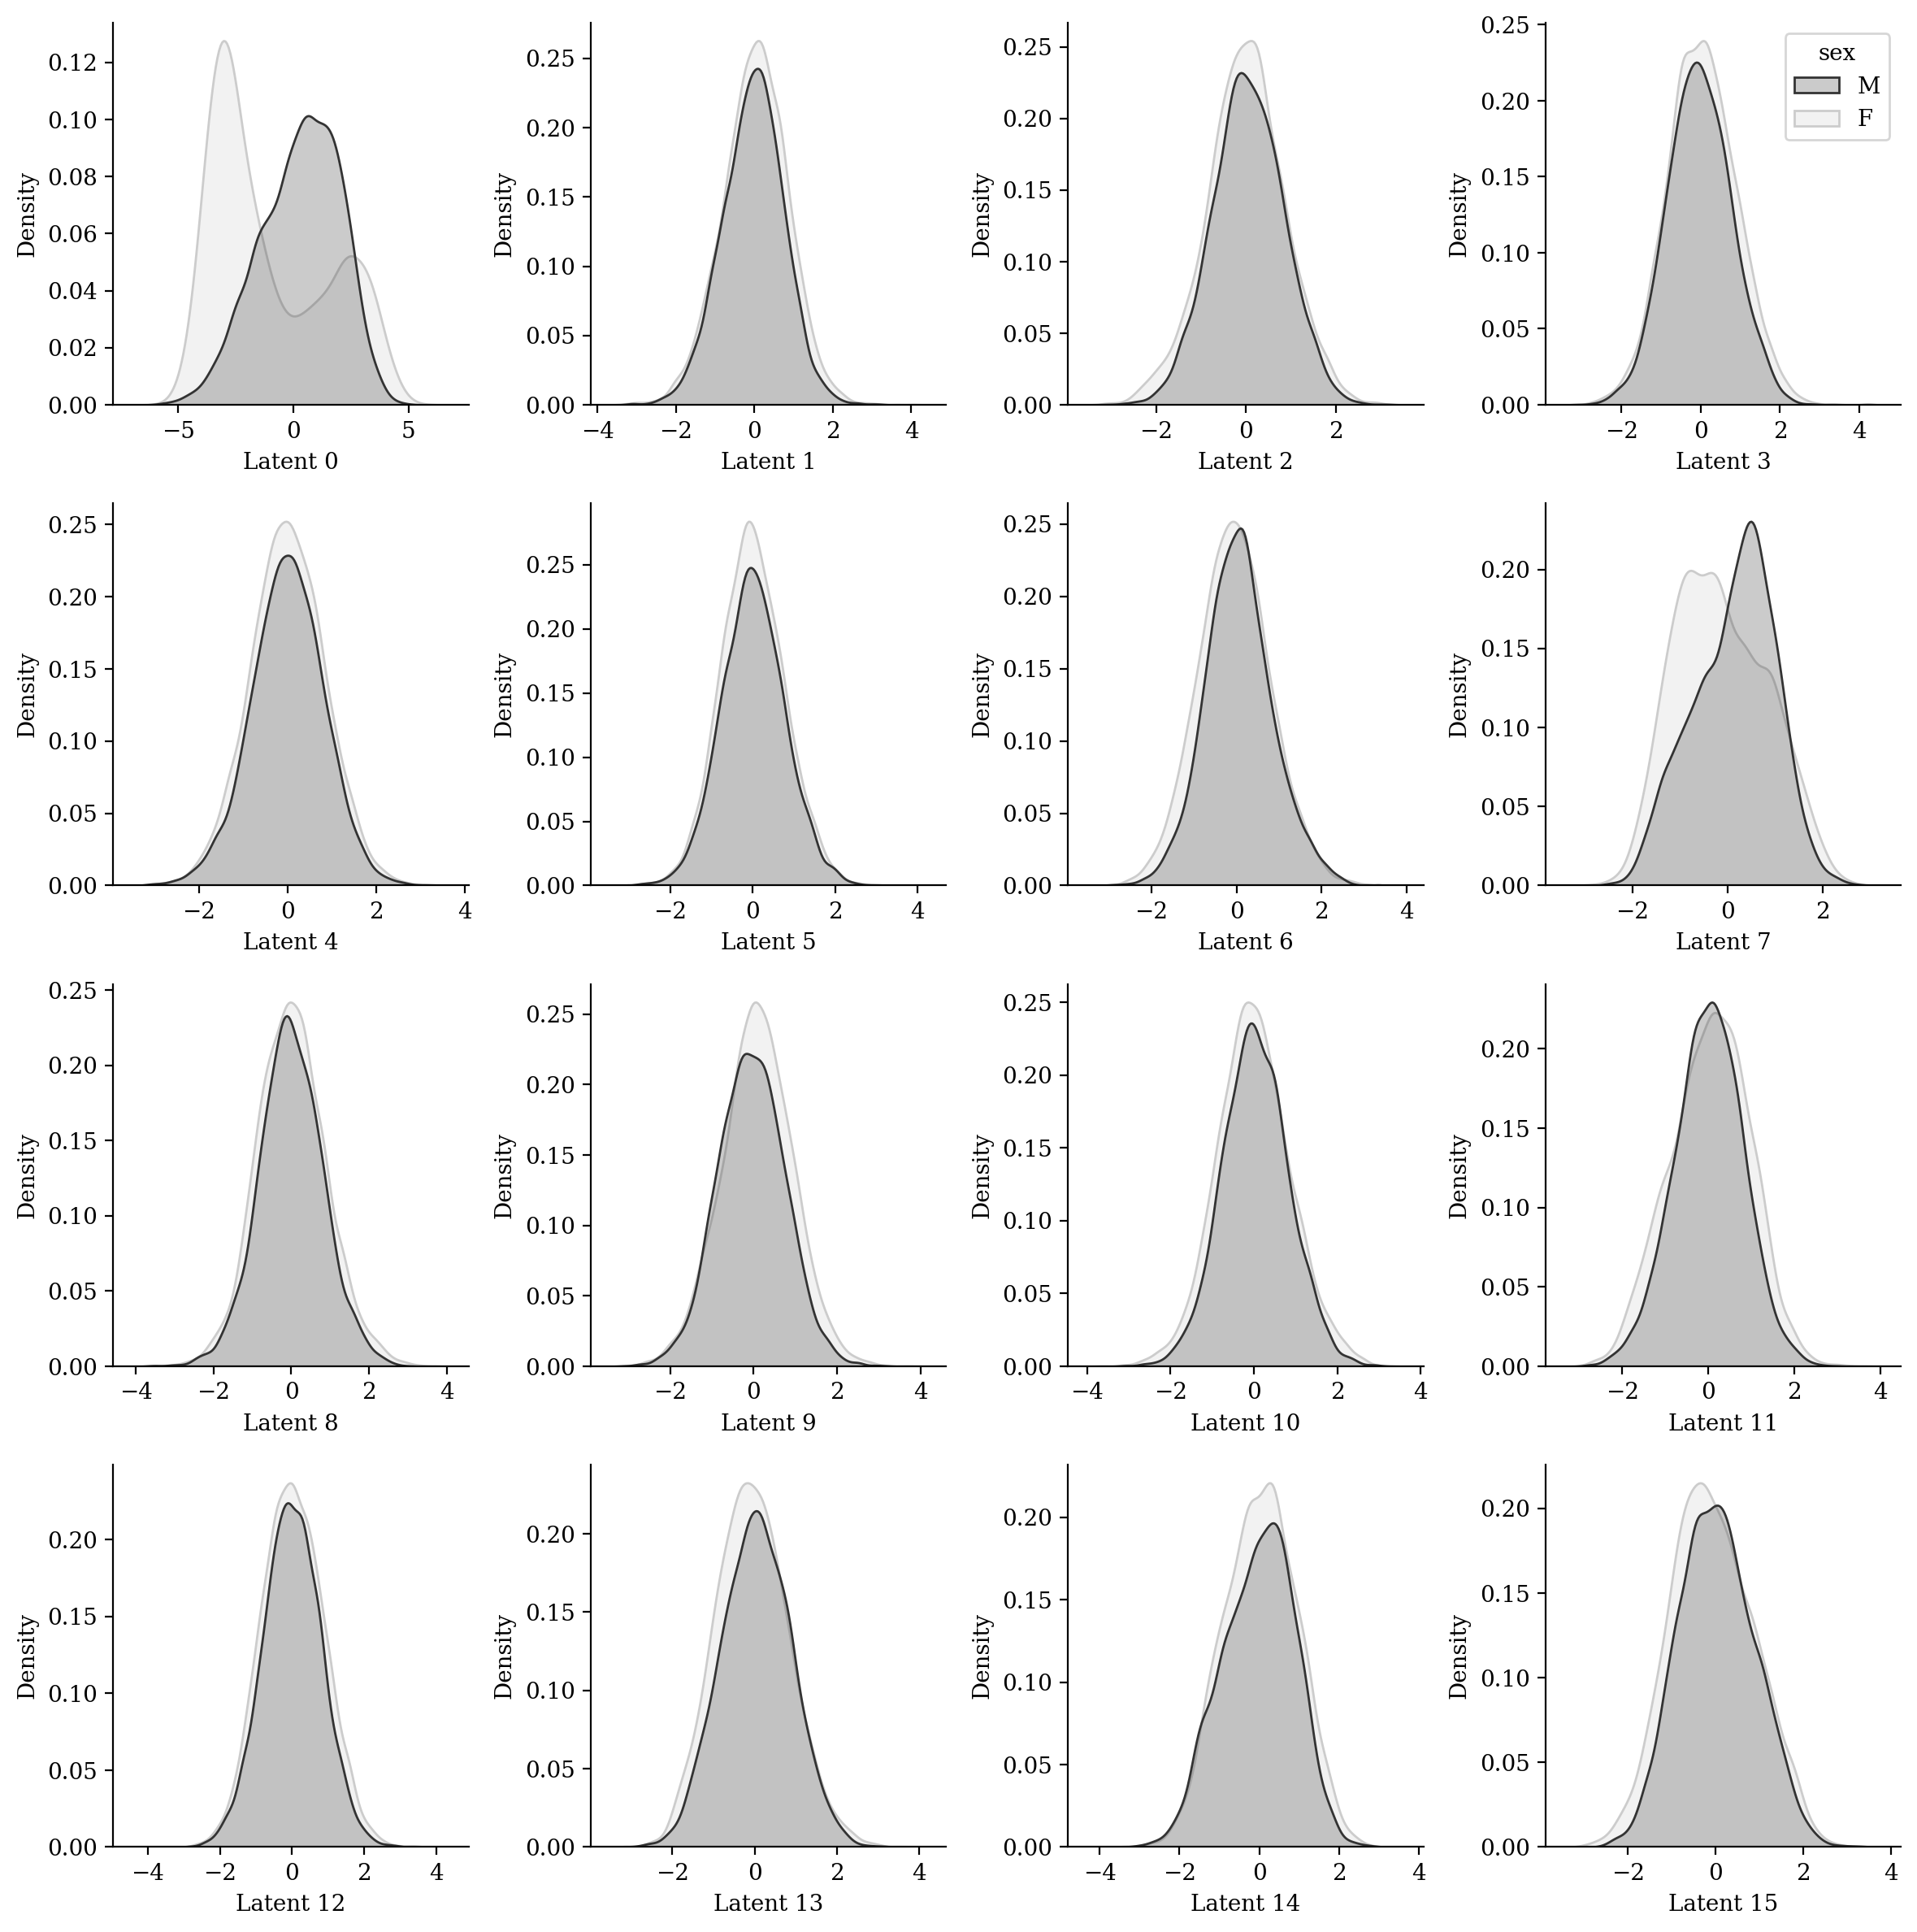

In [ ]:
vae.plot_latent_kde(
    adata_obs=adata.obs,
    target_obs_key="sex",
    latent_representation=vae.get_latent_representation(),
    latent_dim_of_interest=None
)

# Playground

# Visualization

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent, min_dist=0.2)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["sex", "sex_inferred", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )
    
del latent
gc.collect();

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent, min_dist=0.2)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["sex", "sex_inferred", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small"
        )
    del _latent
    gc.collect();

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("sex").unreserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent, min_dist=0.2)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["sex", "sex_inferred", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("sex").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent, min_dist=0.2)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["sex", "sex_inferred", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("sex").unreserved_latent_indices], obs=adata.obs.copy())
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent, min_dist=0.2)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["sex", "sex_inferred", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small"
        )
    del _latent
    gc.collect();
    
del latent
gc.collect();